#  Compare biclusters detected in TCGA and METABRIC


In [1]:
import pandas as pd
from collections import OrderedDict

import sys
sys.path.insert(0, '..')
from unpast.utils.io import read_bic_table
from unpast.utils.eval import evaluate_overlaps_ARI, apply_bh, find_best_matching_biclusters
from unpast.utils.figs import draw_heatmap2


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# input folders 
data_dir = "../data/breast_cancer/"
# output  olders 
out_dir = "../../Supplementary_tables_and_data/TableS2/"
img_dir = "../../img/"


In [3]:
# reading expressions and metadata
subt_anno_tcga = pd.read_csv(data_dir+"TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv.gz",sep ="\t",index_col=0)
anno_tcga = pd.read_csv(data_dir+"TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv.gz",sep ="\t",index_col=0)
anno_tcga = pd.concat([anno_tcga.loc[subt_anno_tcga.index,:], subt_anno_tcga],axis=1)
anno_tcga["stage_34"] = anno_tcga["stage_3"] + anno_tcga["stage_4"] 

subt_anno_meta = pd.read_csv(data_dir+"METABRIC_1904_17Kgenes.subtypes_and_signatures_v6.tsv.gz",sep ="\t",index_col=0)
anno_meta = pd.read_csv(data_dir+"METABRIC_1904.annotation_v6.tsv.gz",sep ="\t",index_col=0)
anno_meta = pd.concat([anno_meta.loc[subt_anno_meta.index,:], subt_anno_meta],axis=1)
anno_meta["stage_34"] = anno_meta["stage_3"] + anno_meta["stage_4"]

exprs_tcga = pd.read_csv(data_dir+"TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.log2_exprs_z_v6.tsv.gz",sep = "\t",index_col=0)
exprs_meta = pd.read_csv(data_dir+"METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv.gz",sep = "\t",index_col=0)

In [4]:
# pre-computed biclusters
analysis_seed = 42
suffix = ".consensus_seed="+str(analysis_seed)+".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"

bics_tcga = read_bic_table("../../outputs/TCGA-BRCA/UnPaSt/optimized/TCGA-BRCA"+suffix)
print("Biclusters in Discovery dataset:", bics_tcga.shape[0])
bics_tcga = bics_tcga.loc[bics_tcga["detected_n_times"]>1,:]
print("\t:", bics_tcga.shape[0])

bics_meta = read_bic_table("../../outputs/METABRIC/UnPaSt/optimized/METABRIC"+suffix)
print("Biclusters in Validation dataset:", bics_meta.shape[0])
bics_meta = bics_meta.loc[bics_meta["detected_n_times"]>1,:]
print("\t:", bics_meta.shape[0])

Biclusters in Discovery dataset: 209
	: 209
Biclusters in Validation dataset: 180
	: 180


# similarity to PAM50 subtypes

In [5]:
all_samples_meta = set(exprs_meta.columns.values)
subts_meta = {}
subts_meta["Luminal"] = set([])
for subt in set(anno_meta["PAM50"].values):
    #if not subt.startswith("Lum"):
    subts_meta[subt] = set(anno_meta.loc[anno_meta["PAM50"]==subt,:].index.values)
    print(subt, len(subts_meta[subt]))
    if subt.startswith("Lum"):
        subts_meta["Luminal"] |= set(anno_meta.loc[anno_meta["PAM50"]==subt,:].index.values)
    


pvals_meta, is_enriched_meta, ari_meta = evaluate_overlaps_ARI(bics_meta, subts_meta, all_samples_meta)
adj_pvals_meta  = apply_bh(pvals_meta, a = 0.05)
adj_pvals_meta["min_pval_META"] = adj_pvals_meta.min(axis=1)
ari_meta["max_ARI_META"] = ari_meta.max(axis=1)

LumA 598
LumB 764
Basal 244
Normal 54
Her2 244


In [6]:
pvals_meta.loc[pvals_meta["LumA"]>0.01,:].sort_values(by='LumB')

,Normal,Basal,Her2,LumA,LumB,Luminal
8,4.182916e-02,0.266123,2.674539e-07,0.015884,0.000001,4.649751e-07
63,2.575852e-01,0.003394,3.319199e-01,0.016369,0.000002,4.506058e-04
1,3.624859e-01,0.000002,1.719605e-04,0.742278,0.000002,2.096358e-06
73,4.341467e-07,0.000002,2.059067e-06,0.036337,0.000003,2.929354e-06
58,5.593979e-02,0.000002,1.784842e-06,0.051575,0.000003,2.148728e-06
27,1.952768e-03,0.000002,2.461274e-06,0.587849,0.000003,2.088950e-06
46,3.124443e-03,0.000001,1.078222e-06,0.423842,0.000003,2.207781e-06
52,7.534179e-07,0.000003,1.623591e-02,0.094793,0.000003,3.451166e-06
166,2.016191e-04,0.000002,1.676166e-04,0.032363,0.000003,3.392825e-06
84,4.118725e-06,0.000002,2.279140e-06,0.215586,0.000003,3.392825e-06


In [7]:
all_samples_tcga = set(exprs_tcga.columns.values)

subts_tcga = {}
subts_tcga["Luminal"] = set([])
for subt in set(anno_tcga["PAM50"].values):
    subts_tcga[subt] = set(anno_tcga.loc[anno_tcga["PAM50"]==subt,:].index.values)
    print(subt, len(subts_tcga[subt]))
    if subt.startswith("Lum"):
        subts_tcga["Luminal"] |= set(anno_tcga.loc[anno_tcga["PAM50"]==subt,:].index.values)
    


pvals_tcga, is_enriched, ari_tcga = evaluate_overlaps_ARI(bics_tcga, subts_tcga, all_samples_tcga)
adj_pvals_tcga  = apply_bh(pvals_tcga, a = 0.05)
adj_pvals_tcga["min_pval_TCGA"] = adj_pvals_tcga.min(axis=1)
ari_tcga["max_ARI_TCGA"] = ari_tcga.max(axis=1)

LumA 426
LumB 318
Basal 195
Normal 32
Her2 108


In [8]:
bics_tcga["max_ARI"] = ari_tcga.loc[bics_tcga.index,"max_ARI_TCGA"]
bics_meta["max_ARI"] = ari_meta.loc[bics_meta.index,"max_ARI_META"]

# Best matches

* significant
* J>=0.1

most interesting - with low max. ARI in TCGA and METABRIC 

In [9]:
b1 = bics_tcga
b2 = bics_meta
print(b1.shape[0],b2.shape[0])
bm = find_best_matching_biclusters(b1,b2,(exprs_tcga.shape[0],0), by="genes")

bics_tcga["bm_id"] = bm.loc[bics_tcga.index,"bm_id"]
bics_tcga["bm_J"] = bm.loc[bics_tcga.index,"J"]

209 180


In [10]:
bm = bm.dropna()
print("matched:",bm.shape[0])
bm = bm.loc[bm["J"]>=0.1,:].sort_values("n_shared_genes",ascending =False)
print("matched with J>=0.1:",bm.shape[0])
bm["union_genes"] = bm.apply(lambda row: row["genes"] | row["bm_genes"],axis=1)
bm["n_union_genes"] = bm["union_genes"].apply(len)
cols = [x for x in bm.columns if not "shared_samples" in x]
bm = bm.loc[:,cols]

matched: 75
matched with J>=0.1: 45


In [11]:
df = pd.concat([bm,adj_pvals_tcga.loc[bm.index.values,['min_pval_TCGA']],
                ari_tcga.loc[bm.index.values,['max_ARI_TCGA']]], axis=1)
df = df.join(adj_pvals_meta.loc[bm["bm_id"].values,['min_pval_META']], on="bm_id")
df = df.join(ari_meta.loc[bm["bm_id"].values,['max_ARI_META']], on="bm_id")

df = df.drop_duplicates(subset=["bm_id","n_genes","n_samples","n_shared_genes"]).sort_values(by = "n_shared_genes",ascending = False)

In [12]:
d = df.loc[:,:].copy()
cols = ["genes", "samples","shared_genes","bm_genes","bm_samples"]
for col in cols:
    d[col] = d[col].apply(lambda x: " ".join(sorted(x)) ) 
d.to_csv(out_dir + "45_matched_J0.1.tsv",sep="\t")

In [13]:
df["max_ARI"] = df.apply(lambda x: max(x["max_ARI_TCGA"],x["max_ARI_META"]),axis=1)
potentially_novel = df.loc[df["max_ARI"]<0.25,:]
print(potentially_novel.shape[0])
potentially_novel

34


,bm_id,J,adj_pval,genes,n_genes,n_samples,samples,shared_genes,n_shared_genes,bm_genes,bm_n_genes,bm_n_samples,bm_samples,union_genes,n_union_genes,min_pval_TCGA,max_ARI_TCGA,min_pval_META,max_ARI_META,max_ARI
64,35,0.354839,0.0,"{CMC2, IST1, KARS1, BRD7, NAE1, AARS1, PSMD7, ...",20,492,"{TCGA-B6-A0WT-01, TCGA-BH-A0BC-01, TCGA-A2-A25...","{CMC2, USB1, NUP93, IST1, KARS1, BRD7, COQ9, A...",11,"{CMC2, TUBB3, KATNB1, IST1, KARS1, BRD7, AARS1...",22,853,"{MB-6063, MB-6114, MB-0223, MB-2984, MB-2951, ...","{CMC2, TUBB3, KATNB1, IST1, KARS1, BRD7, NAE1,...",31,0.000005,0.177823,0.000005,0.206861,0.206861
100,163,0.268293,0.0,"{TRARG1, PRG4, CNTFR, ADH1C, CTSG, CIDEC, PLIN...",18,526,"{TCGA-AR-A24V-01, TCGA-B6-A0WT-01, TCGA-AO-A03...","{PRG4, CNTFR, CIDEC, PLIN4, FABP4, PLIN1, THRS...",11,"{LPL, MAOA, CNTFR, SAA1, THRSP, PLIN4, HSPB6, ...",34,465,"{MB-6079, MB-5179, MB-0537, MB-2951, MB-0623, ...","{TRARG1, LPL, MAOA, CNTFR, SAA1, THRSP, PLIN4,...",41,0.000005,0.079060,0.000006,0.086055,0.086055
128,60,0.36,0.0,"{IFIT1, IFNL2, MX1, IFI44L, CMPK2, BATF2, IFI2...",16,413,"{TCGA-AR-A24V-01, TCGA-BH-A0BC-01, TCGA-AO-A03...","{IFIT1, MX1, IFI44L, BATF2, CMPK2, IFI27, OASL...",9,"{IFIT1, MX1, RSAD2, IFI44L, CMPK2, BATF2, IFI2...",18,658,"{MB-5179, MB-0537, MB-0223, MB-2984, MB-7019, ...","{IFIT1, IFI44L, CMPK2, IFNL1, IFIT2, IFI6, OAS...",25,0.000005,0.072839,0.000005,0.080350,0.080350
5,5,0.186047,0.0,"{GPR148, ACTL6B, CARTPT, HRH3, ELFN2, XKR7, SL...",23,48,"{TCGA-BH-A1FR-01, TCGA-A8-A08L-01, TCGA-E2-A10...","{SLITRK1, CHGB, CHGA, SEZ6, ACTL6B, SYT4, CART...",8,"{SLC6A17, SCG3, OGDHL, ACTL6B, PCSK1, CARTPT, ...",28,66,"{MB-4008, MB-5044, MB-7076, MB-3748, MB-5197, ...","{SLC6A17, GPR148, SCG3, OGDHL, ACTL6B, PCSK1, ...",43,0.001616,0.036731,0.000007,0.010488,0.036731
36,22,0.106383,0.0,"{CFHR4, H2BW1, VCX, SOHLH1, C12orf56, GABRA3, ...",44,93,"{TCGA-A2-A0EY-01, TCGA-A8-A06Z-01, TCGA-AN-A0F...","{CSAG2, CTAG2, CSAG1, MAGEA10, MAGEA6}",5,"{MAGEA9B, MAGEA4, CSAG2, CTAG2, DSCR8, CSAG1, ...",8,99,"{MB-0627, MB-3153, MB-0370, MB-0656, MB-5209, ...","{CFHR4, H2BW1, VCX, SOHLH1, C12orf56, GABRA3, ...",47,0.000007,0.086784,0.000005,0.116247,0.116247
63,142,0.142857,0.0,"{MED30, MTFR1, PABPC1, POP1, SLC52A2, ZNF706, ...",26,439,"{TCGA-AR-A24V-01, TCGA-A2-A25E-01, TCGA-A2-A0C...","{MTFR1, MTERF3, ELOC, SQLE}",4,"{MTFR1, TMEM70, RRS1, MTERF3, SQLE, ELOC}",6,698,"{MB-6079, MB-6114, MB-0872, MB-2984, MB-5197, ...","{MED30, MTFR1, PABPC1, POP1, EMC2, TMEM70, NSM...",28,0.000005,0.160523,0.000005,0.082378,0.160523
140,139,0.142857,0.0,"{CYP4A11, SP5, WFDC6, HABP2, ABCC11, FAM170A, ...",26,537,"{TCGA-AR-A24V-01, TCGA-A2-A25E-01, TCGA-A2-A0C...","{SOWAHA, SHROOM1, HMGCS2, LRRC31}",4,"{FRMPD3, LRRC31, SOWAHA, GDF9, SHROOM1, HMGCS2}",6,492,"{MB-5179, MB-4667, MB-0872, MB-2933, MB-5425, ...","{CYP4A11, GPR162, SP5, WFDC6, HABP2, LRRC31, A...",28,0.000005,0.170886,0.000005,0.075881,0.170886
55,18,0.4,0.0,"{HOXB-AS3, HOXB5, HOXB6, HOXB1, LGALS9B, HOXB4}",6,268,"{TCGA-C8-A12O-01, TCGA-E2-A1B5-01, TCGA-EW-A1P...","{HOXB4, HOXB-AS3, HOXB6, HOXB5}",4,"{HOXB-AS3, HOXB5, HOXB7, HOXB6, HOXB4, HOXB3, ...",8,348,"{MB-5179, MB-4667, MB-2933, MB-5197, MB-5495, ...","{HOXB-AS3, HOXB5, HOXB6, HOXB1, LGALS9B, HOXB4...",10,0.000005,0.048111,0.000005,0.024702,0.048111
151,81,0.6,0.0,"{H1-6, H4C8, H2BC4, H1-2}",4,505,"{TCGA-B6-A0WT-01, TCGA-A2-A25E-01, TCGA-A2-A0C...","{H1-2, H2BC4, H4C8}",3,"{H4C8, H3C4, H2BC4, H1-2}",4,636,"{MB-6079, MB-5533, MB-4651, MB-7028, MB-3005, ...","{H1-6, H1-2, H2BC4, H3C4, H4C8}",5,0.001167,0.011981,0.000005,0.043196,0.043196
114,55,0.1875,0.0,"{CALML3, TP63, KRT14, TENM2, COL17A1, NTF4, KR...",9,417,"{TCGA-A2-A1G4-01, TCGA-E2-A9RU-01, TCGA-WT-AB4...","{CALML3, TP63, COL17A1}",3,"{CALML3, OPRPN, TP63, DST, MYL7, PAMR1, NSG1, ...",10,458,"{MB-0537, MB-0223, MB-0872, MB-2951, MB-5495, ...","{NTF4, PIGR, COL17A1, FAT2, DSG3, ECRG4, CALML...",16,0.000007,0.144174,0.000006,0.238485,0.238485


In [14]:
d = potentially_novel.loc[:,:].copy()
cols = ["genes", "samples","shared_genes","union_genes","bm_genes","bm_samples"]
for col in cols:
    d[col] = d[col].apply(lambda x: " ".join(sorted(x)) ) 
d.to_csv(out_dir + "28_matched_J0.1_ARI0.25.tsv",sep="\t")

### plot top-5 similar biclusters not matching PAM50


In [15]:
subt_order = ["Her2","Basal","LumA","LumB","Normal"]

color_dict = OrderedDict()

color_dict["PAM50"] = OrderedDict({"Her2":"yellow",
                                   "Basal":"lightblue",
                                   "LumA":"lightgreen",
                                   "LumB":"darkgreen",
                                   "Normal":"grey"})

color_dict["claudin_low"] = OrderedDict({1:"magenta",0:"grey"}) # claudin-low

color_dict["sex"] = OrderedDict({1:"lightpink",0:"lightblue",
                                 "F":"lightpink","M":"lightblue"})
 

# histology
receptors = OrderedDict({'Positive':"red",
                         "Equivocal":"grey",#"orange",
                         'Indeterminate':"grey",#"gold",
                         'Negative':"green",
                         "NA":"lightgrey"})
color_dict["IHC_HER2"] = receptors
color_dict["IHC_ER"] = receptors 
color_dict["IHC_PR"] = receptors 



In [16]:
# show only shared genes
gene_list = set([])
for genes in potentially_novel.head(5)["shared_genes"]:
    gene_list |= genes


In [17]:
top_n = 5

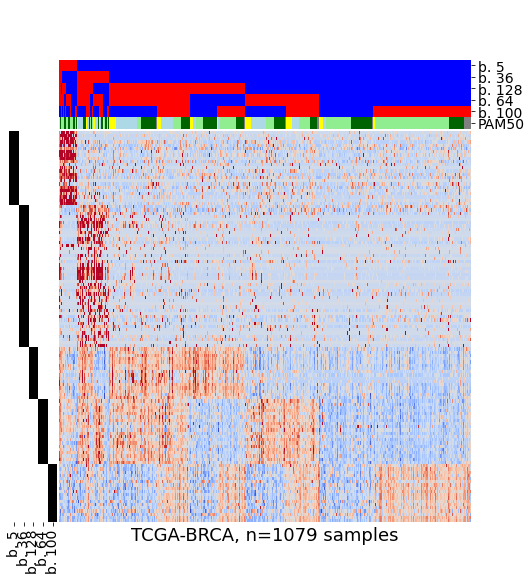

In [18]:
w = 8
fs = 12 # Font size
subt_anno = anno_tcga.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)
top_n = 5

bics = bics_tcga.loc[potentially_novel.head(top_n).sort_values(by="n_samples").index.values, :]

sele_bics = bics.index.values
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
if w>h:
    cr = max(min(0.015,0.05*h/10),0.05)
else:
    cr = min(max(0.015,0.015*h/10),0.05)
fig, samples, colors = draw_heatmap2(exprs_tcga.copy(),
                    bics.loc[sele_bics,:],
                    annot=subt_anno,
                    color_dict=color_dict,
                  bicluster_colors="redblue",
                  figsize = (w,h*0.8), 
                  dendrogram_ratio=(0.1,0.1),
                  colors_ratio=(cr/w*h, cr*1.5),
                  bic_prefix = "b. ",
                  legend_n_cols=0,
                  no_cbar=True,
                  col_labels = False,
                  #highlight_row_labels=highlight_genes,
                  #row_labels = True,
                  no_row_colors = False,
                  cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-BRCA, n=%s samples"%subt_anno.shape[0],fontsize=18)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=14)
tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=14)

### same genes but clustered

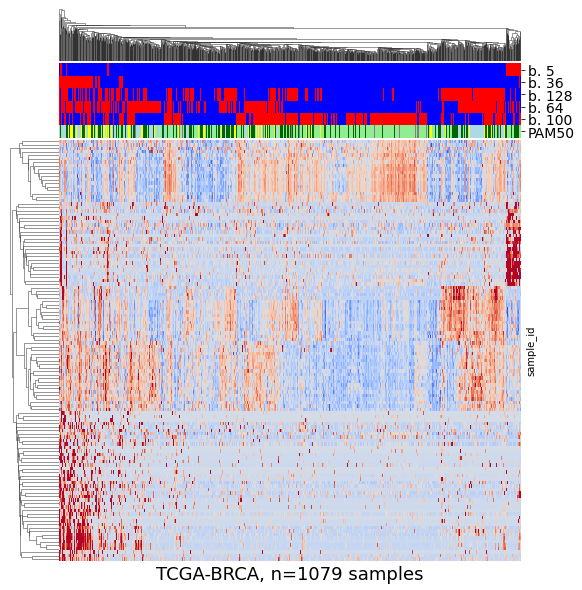

In [19]:
import seaborn as sns
df = colors[0].copy()
d = {"white":0,"black":1}
df = df.applymap(lambda x:d[x])
df = df[df.sum(axis=1)>0]
df = df.sort_values(by=list(df.columns.values),ascending=False)
fig = sns.clustermap(fig.data2d.loc[list(df.index.values),
                                    samples],
                       col_cluster=True,#row_cluster=True,
                       cmap=sns.color_palette("coolwarm", as_cmap=True),
                       vmin=-3,vmax=3,
                       xticklabels=False, yticklabels=False,
                       col_colors=colors[1],
                       #row_colors=colors[0],
                       figsize=(w,h*0.8), 
                       dendrogram_ratio=(0.1,0.1),
                       colors_ratio=(cr/w*h, cr*1.5),)
fig.cax.set_visible(False)
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-BRCA, n=%s samples"%subt_anno.shape[0],fontsize=18)
tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=14)
#tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=14)

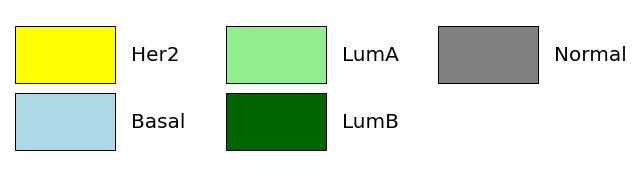

In [20]:
from matplotlib.patches import Patch

legend_elements = []
for subt in color_dict["PAM50"].keys():
    p = Patch(facecolor=color_dict["PAM50"][subt], edgecolor='black', label=subt)
    legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots(figsize = (3,3))
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=3,
    handlelength=5,
    handleheight=4,
    title='',  # Legend title
    fontsize=20  # Legend items font size
)

legend.get_frame().set_alpha(0)

legend.set_title('', prop={'size': 22})

ax.axis('off')

plt.show()


# top-5 biclusters with the highest number of shared genes

In [21]:
sns.set(font_scale=0.5)

colors: ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc']


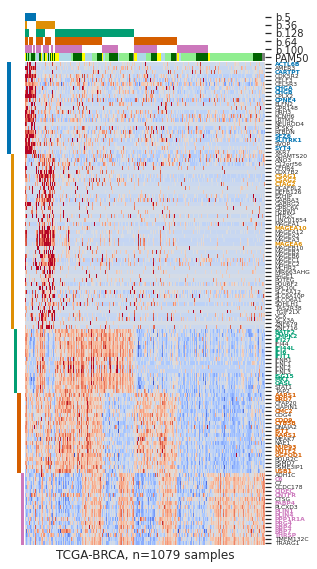

In [22]:
subt_anno = anno_tcga.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)

bics = bics_tcga.loc[potentially_novel.head(top_n).sort_values(by="n_samples").index.values, :]

w, h = 4.5,8

tmp = draw_heatmap2(exprs_tcga,
                    bics,
                    figsize = (w,h), 
                    colors_ratio=(cr/w*h/2, cr),
                    dendrogram_ratio=(0.0,0.01),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="auto",
                    col_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    legend_n_cols=0,
                    no_cbar = True,
                    cluster_rows=False,
                    highlight_row_labels=list(gene_list),
                   bic_prefix="b.",
                                    )
                
fname = "5bics_TCGA"
ax = tmp[0].ax_heatmap
ax.set_xlabel("TCGA-BRCA, n=%s samples"%exprs_tcga.shape[1], fontsize=12)
tmp[0].ax_row_colors.set_xticklabels([""]*(bics.shape[0]))
tmp[0].ax_row_colors.set_xticks([])
tmp[0].ax_col_colors.set_yticklabels(tmp[0].ax_col_colors.get_yticklabels(),fontsize=10)
tmp[0].ax_heatmap.set_yticklabels(ax.get_yticklabels(),fontsize=6)

for ext in ["png","pdf","svg"]:
    plt.savefig(img_dir+"FigS9/FigS9c_"+fname+"_v4."+ext,format=ext, dpi = 300)
plt.show()

In [ ]:
subt_anno = anno_meta.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)

bics = bics_meta.loc[potentially_novel.head(top_n).sort_values(by="n_samples")["bm_id"].values, :]

tmp =draw_heatmap2(exprs_meta,
                    bics,
                    figsize = (w,h), 
                    colors_ratio=(cr/w*h/2, cr),
                    dendrogram_ratio=(0.0,0.01),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="auto",
                    col_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    legend_n_cols=0,
                    no_cbar = True,
                    cluster_rows=False,
                    highlight_row_labels=list(gene_list),
                   bic_prefix="b.")

fname = "5bics_METABRIC"
ax = tmp[0].ax_heatmap
ax.set_xlabel("METABRIC, n=%s samples"%exprs_meta.shape[1], fontsize=12)
tmp[0].ax_row_colors.set_xticklabels([""]*(bics.shape[0]))
tmp[0].ax_row_colors.set_xticks([])
tmp[0].ax_col_colors.set_yticklabels(tmp[0].ax_col_colors.get_yticklabels(),fontsize=10)
tmp[0].ax_heatmap.set_yticklabels(ax.get_yticklabels(),fontsize=6)

for ext in ["png","pdf","svg"]:
    plt.savefig(img_dir+"FigS9/FigS9d_"+fname+"_v4."+ext,format=ext, dpi = 300)
plt.show()

colors: ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc']


### same signatures, but only shared genes are shown

In [ ]:
subt_anno = anno_tcga.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)

bics = bics_tcga.loc[potentially_novel.head(top_n).sort_values(by="n_samples").index.values, :]
for col in ["genes","genes_up","genes_down"]:
    bics[col] = bics[col].apply(lambda x: x.intersection(gene_list))

w, h = 4.5,6

tmp = draw_heatmap2(exprs_tcga,
                    bics,
                    figsize = (w,h), 
                    colors_ratio=(cr/w*h, cr*1.25),
                    dendrogram_ratio=(0.0,0.01),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="auto",
                    col_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    legend_n_cols=0,
                    no_cbar = True,
                    cluster_rows=False,
                    highlight_row_labels=list(gene_list),
                   bic_prefix="b.",
                                    )
                
fname = "5bics_TCGA_shared_genes"
ax = tmp[0].ax_heatmap
ax.set_xlabel("TCGA-BRCA, n=%s samples"%exprs_tcga.shape[1], fontsize=12)
tmp[0].ax_row_colors.set_xticklabels([""]*(bics.shape[0]))
tmp[0].ax_row_colors.set_xticks([])
tmp[0].ax_col_colors.set_yticklabels(tmp[0].ax_col_colors.get_yticklabels(),fontsize=8)
tmp[0].ax_heatmap.set_yticklabels(ax.get_yticklabels(),fontsize=8)
#tmp[0].fig.text(0.02, 0.03, "", ha='left', va='bottom', fontsize=18)

for ext in ["png","pdf","svg"]:
    plt.savefig(img_dir+"Fig4/Fig4c"+fname+"_v4."+ext,format=ext, dpi = 300)
plt.show()

In [ ]:
subt_anno = anno_meta.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)

bics = bics_meta.loc[potentially_novel.head(top_n).sort_values(by="n_samples")["bm_id"].values, :]
for col in ["genes","genes_up","genes_down"]:
    bics[col] = bics[col].apply(lambda x: x.intersection(gene_list))

w, h = 4.5,6


tmp = draw_heatmap2(exprs_meta,
                    bics,
                    figsize = (w,h), 
                    colors_ratio=(cr/w*h, cr*1.25),
                    dendrogram_ratio=(0.0,0.01),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="auto",
                    col_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    legend_n_cols=0,
                    no_cbar = True,
                    cluster_rows=False,
                    highlight_row_labels=list(gene_list),
                   bic_prefix="b.",
                                    )


fname = "5bics_METABRIC_shared_genes"
ax = tmp[0].ax_heatmap
ax.set_xlabel("METABRIC, n=%s samples"%exprs_meta.shape[1], fontsize=12)
tmp[0].ax_row_colors.set_xticklabels([""]*(bics.shape[0]))
tmp[0].ax_row_colors.set_xticks([])
tmp[0].ax_col_colors.set_yticklabels(tmp[0].ax_col_colors.get_yticklabels(),fontsize=8)
tmp[0].ax_heatmap.set_yticklabels(ax.get_yticklabels(),fontsize=8)
#tmp[0].fig.text(0.02, 0.03, "", ha='left', va='bottom', fontsize=18)

for ext in ["png","pdf","svg"]:
    plt.savefig(img_dir+"Fig4/Fig4d"+fname+"_v4."+ext,format=ext, dpi = 300)
plt.show()

# Legend 

In [ ]:
from matplotlib.patches import Patch
ncol = 5


legend_elements = []
colors = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc']
labels = bics.index.values
for i in range(len(labels)):
    p = Patch(facecolor=colors[i], edgecolor='black', label=labels[i])
    legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots(figsize = (10,2)) # 
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=ncol,
    handlelength=3,
    handleheight=1.5,
    title='',  # Legend title
    fontsize=20  # Legend items font size
)



legend.get_frame().set_alpha(0)

legend.set_title('', prop={'size': 22})

ax.axis('off')
plt.savefig(img_dir+"Fig4/color_legend_bics.svg")

legend_elements = []
for subt in color_dict["PAM50"].keys():
    p = Patch(facecolor=color_dict["PAM50"][subt], edgecolor='black', label=subt)
    legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots(figsize = (10,2)) # 
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=ncol,
    handlelength=3,
    handleheight=1.5,
    title='',  # Legend title
    fontsize=20  # Legend items font size
)

legend.get_frame().set_alpha(0)

legend.set_title('', prop={'size': 22})

ax.axis('off')


plt.savefig(img_dir+"Fig4/color_legend_PAM50.svg")

plt.show()


In [ ]:
df = potentially_novel.sort_values(by="n_shared_genes",ascending=False)
df["id_TCGA"] = df.index.values
df["id_METABRIC"] = df["bm_id"]
df["Jaccard"] = df["J"].apply(lambda x: round(x,2))
df["n_shared"] = df["shared_genes"].apply(lambda row:len(row))
df["shared"] = df["shared_genes"].apply(lambda row:" ".join(sorted(row)))
df["union"] = df.apply(lambda row: row['genes']|row['bm_genes'],axis=1)
df["n_union"] = df["union"].apply(lambda row:len(row))
df["union"] = df.apply(lambda row:" ".join(sorted(row['union'])),axis=1)
df["n_genes_TCGA"] = df["n_genes"]
df["genes_TCGA"] = df["genes"].apply(lambda row:" ".join(sorted(row)))
df["n_genes_METABRIC"] = df["bm_n_genes"]
df["genes_METABRIC"] = df["bm_genes"].apply(lambda row:" ".join(sorted(row)))
df["n_samples_TCGA"] = df["n_samples"]
df["samples_TCGA"] = df["samples"].apply(lambda row:" ".join(sorted(row)))
df["n_samples_METABRIC"] = df["bm_n_samples"]
df["samples_METABRIC"] = df["bm_samples"].apply(lambda row:" ".join(sorted(row)))
cols = ["id_TCGA","id_METABRIC","Jaccard","n_shared","shared","n_union","union",
       "n_genes_TCGA","genes_TCGA","n_genes_METABRIC","genes_METABRIC",
       "n_samples_TCGA","samples_TCGA","n_samples_METABRIC","samples_METABRIC"]
df = df.loc[:,cols]
df = df.sort_values(by=["n_shared","n_union"],ascending=[False,False])
df.index = range(df.shape[0])
df.index.name = "pair_id"
df.to_csv(out_dir+'TableS2_potentially_novel.tsv',sep = "\t")
df